In [52]:
import pandas as pd 

import matplotlib.pyplot as plt
# we use xgboost gradient boosting decsion trees model for this experiment 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import xgboost as xgb

import scikitplot as skplt

In [53]:
df = pd.read_csv('./data/moral_appeal_dataset.csv')
df

,ad,moral_appeal
0,psd jobs spring launch webinar monday pmpm vir...,0
1,the aflcio has always fought alongside workers...,1
2,your national monuments are on the chopping block,0
3,join us for a focus group to share your though...,0
4,with president trump nominating a judge with a...,1
...,...,...
19729,what is senator heidi heitkamp hiding watch be...,0
19730,breaking the washington post just reported on ...,0
19731,protecting vermont is injured employees contac...,1
19732,according to the huffington post days after pa...,0


In [4]:
# vectorize testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df['ad'], df['moral_appeal'] , test_size = 0.2, random_state = 0)

In [5]:
tf_vectorizer = TfidfVectorizer()

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [48]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth = 10, 
    subsample = 0.5,
    learning_rate = 0.3,
    gamma = 10,
)
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy:   0.986
                 precision    recall  f1-score   support

no moral appeal       0.97      1.00      0.99      1934
   moral appeal       1.00      0.97      0.99      2013

       accuracy                           0.99      3947
      macro avg       0.99      0.99      0.99      3947
   weighted avg       0.99      0.99      0.99      3947

confusion matrix:
[[1931    3]
 [  52 1961]]



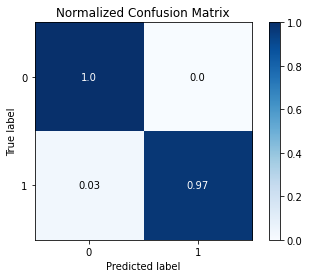

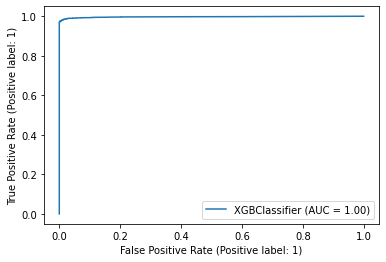

In [30]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# model performance
score = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_test, predictions, target_names=['no moral appeal', 'moral appeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [55]:
df_val = pd.read_csv('./data/sample_moral_appeal.csv').rename(columns = {'moral': 'moral_appeal' })
df_val

,ad,moral_appeal
0,yearold danylo is not only battling cancer but...,1
1,learn how to use the new staffing law to impro...,0
2,we are live with climate activist anuna de wev...,0
3,did you miss the t summit relive the daylong e...,0
4,friday is north carolinas online voter registr...,0
...,...,...
123,if you are a developer who wants to make a dif...,0
124,this is how strongly i felt about this i am no...,0
125,are you interested in environmental crime\nfor...,0
126,on the feb ukrainians woke up to the sound of...,1


accuracy:   0.773
                 precision    recall  f1-score   support

no moral appeal       0.70      0.80      0.75        54
   moral appeal       0.84      0.76      0.79        74

       accuracy                           0.77       128
      macro avg       0.77      0.78      0.77       128
   weighted avg       0.78      0.77      0.77       128

confusion matrix:
[[43 11]
 [18 56]]



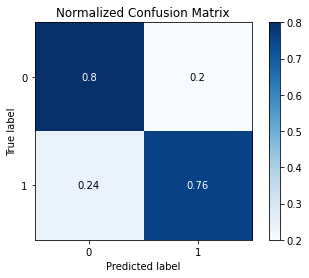

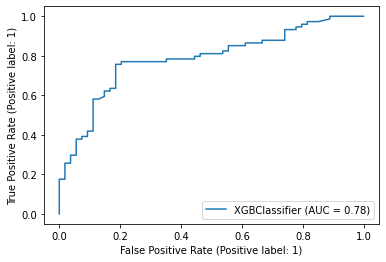

In [56]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['moral_appeal']

y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=['no moral appeal', 'moral appeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)